<center><h2> SVM kernel performance on the MNIST data set

<center><h3> Michelle Hackl
<break>
<center> CS156 - Prof. Sterne

-----

## Data import and visualization
For importing the data set I have used the python-mnist library from https://pypi.org/project/python-mnist/. 



In [2]:
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')

import math
import struct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
'''
Imports and parses the files downloaded from the MNIST website.
I checked these to make sure the training and testing data aren't 
sorted or anything similar that would bias my classifier performance.
'''
from mnist import MNIST

mndata = MNIST('.')
X_train, y_train = mndata.load_training()
X_test, y_test = mndata.load_testing()

In [4]:
'''
Converting to a data frame to make subsetting easier.
'''
X_train = pd.DataFrame(X_train)
y_train = pd.Series(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.Series(y_test)

print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(60000, 784) (60000,)
(10000, 784) (10000,)


In [4]:
'''
Lets take out examples of 1s and 7s and plot them
using the plot_int function below.
'''
X_train_1s = X_train[y_train.values == 1]
X_train_7s = X_train[y_train.values == 7]
print X_train_1s.shape, X_train_7s.shape

(6742, 784) (6265, 784)


Here are some examples of 1s


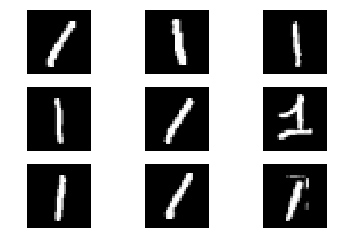

Here are some examples of 7s


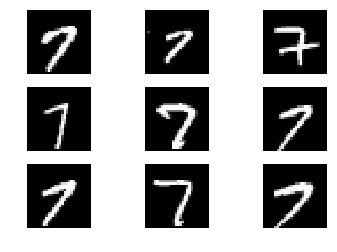

In [5]:
def plot_int(data, amount, num):
    '''
    Plots "amount" number of examples of the digits.
    '''
    print('Here are some examples of {label}s'.format(label=num))

    for i in range(amount):
        plt.subplot(int(math.ceil(amount/3.0)),3,i+1)
        pixels = data.iloc[i].values.reshape((28, 28))
        plt.imshow(pixels, cmap='gray')
        plt.axis('off')
    plt.show()

plot_int(X_train_1s, 9, 1)
plot_int(X_train_7s, 9, 7)

## SVM training - 2 versus 10 classes
Before delving into the different kernels and working on the full data set, I explored what difference in training time I was to expect when trying to classify only 2 digits vs. all 10.  Sklearn's Support Vector Classifier uses a one-vs-one approach for multi-class classification, meaning that it creates a separate classifier for each possible digit pair and then classifies in an ensemble manner. 
This means we have to train 

$\frac{n*(n-1)}{2}$

classifiers (see scaling behavior in plot below). Based on this I explore how training time scales comparatively between a 2 and 10 class classifier with respect to training data.

In [5]:
from sklearn.svm import SVC
import time

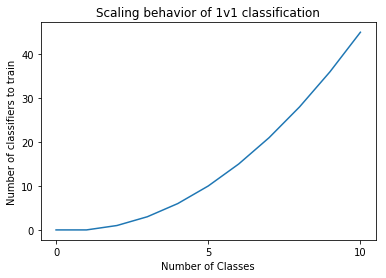

In [7]:
'''
Plotting the expected scaling behavior of 1v1 classification.
'''
x = range(11)
y = [0] * 11

for n in range(11):
    y[n] = (n*(n-1)/2)

plt.plot(x,y)
plt.title('Scaling behavior of 1v1 classification')
plt.xlabel('Number of Classes')
plt.ylabel('Number of classifiers to train')
plt.xticks(np.arange(0, 11, 5))
plt.show()

In [8]:
def plot_train_time_scale(clf, X_train, y_train, reps):
    '''
    Plots training times for a classifier for increasing
    amounts of data points in the range 500-5000 in steps
    of 100. Note that this function runs "reps" times and
    averages over the results for more precise estimations.
    '''
    all_training_times = np.zeros((reps,45))
    for j in range(0,reps):
        train_time_scale = []
        for i in range(500, 5000, 100):
            start = time.time()
            clf.fit(X_train[:i], y_train[:i])
            end = time.time()
            train_time_scale.append(end-start)
        all_training_times[j,:] = train_time_scale
    
    mean_training_time = np.mean(all_training_times, axis=0)
        
    plt.plot(range(len(mean_training_time)), mean_training_time, alpha=0.5)
    plt.ylabel('Average training time in seconds')
    plt.xlabel('Steps')
    plt.show()

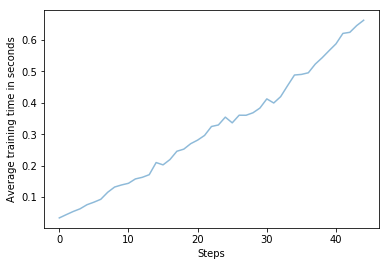

In [9]:
SVM_2classes = SVC(kernel='linear')
SVM_10classes = SVC(kernel='linear')

X_train_1s_7s = X_train[(y_train.values == 1) | (y_train.values == 7)]
y_train_1s_7s = y_train.loc[(y_train.values == 1) | (y_train.values == 7)]

plot_train_time_scale(SVM_2classes, X_train_1s_7s, y_train_1s_7s, 5)

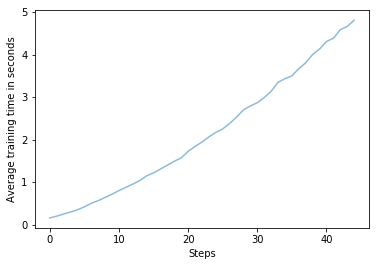

In [10]:
plot_train_time_scale(SVM_10classes, X_train, y_train, 5)

Comparing the training time of the 2-class to that of the 10-class classifier suggests that training takes about 7 times as long with the same amount of data (as opposed to 45 times, as we would expect from having to train 45 individual classifiers). This suggests that the sklearn implementation of SVC has found a more efficient way to train many classifiers than simply having to train each classifier individually.
After reading the sklearn documentation for a bit, I found that the LinearSVC actually does 1-vs-all classification, which would be much closer in training time to what we observe here (it trains 1 classifier for every class). 

**Hypothesis:** In its optimized form, SVC uses 1-vs-all classification methods when trained with a linear kernel.

To test this, let's see what happens if we change the SVM to a non-linear kernel instead.

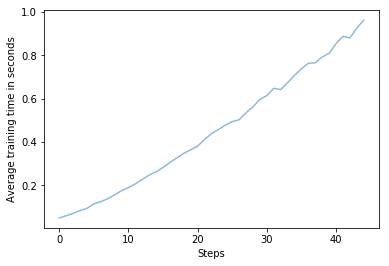

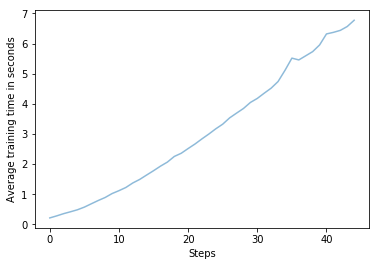

In [11]:
SVM_2classes_poly = SVC(kernel='poly', degree=3)
SVM_10classes_poly = SVC(kernel='poly', degree=3)

plot_train_time_scale(SVM_2classes_poly, X_train_1s_7s, y_train_1s_7s, 5)
plot_train_time_scale(SVM_10classes_poly, X_train, y_train, 5)

This still scales with a constant factor of ~7, which is still not the scaling behavior I would expect to see... I will have to do some further exploration into the sklearn documentation to find out about the ways in which the SVC has been optimized in the background. While this was an interesting exploration, let's get back to the actual question we are trying to test: differences in kernels.


## Differences in Kernels
In this section we are testing 3 different kinds of kernels to test their performance on the holdout test set and record their training times. 
- Linear
- Poly
- RBF

I'll begin by finding the ideal parameters for each kernel on a subset of the training data. Training time is then recorded for the gridsearched classifiers on the total training data. The final report shows confusion matrices and error rates for all kernels.
Note that gamma values (inverse radius of influence of data points) have to be picked carefully with the rbf kernel. High gamma values (default 1.0) mean that the classifier can only consider nearby examples for training, which leads to fitting and prediction issues with the classifier in higher-dimensional space, such as the input data we are using here.

In [6]:
from sklearn.model_selection import GridSearchCV

In [7]:
'''
Using a reduced data set size of only 3000 examples to find 
optimal parameters for each SVC. The next block returns a
list with the ideal classifiers.
'''

SVM_linear = SVC(kernel='linear')
SVM_poly = SVC(kernel='poly')
SVM_gaussian = SVC(kernel='rbf')

X_train_CV = X_train[:3000]
y_train_CV = y_train[:3000]

poly_param = {'degree':[2, 3, 8], 'C':[0.1, 1, 10]}
linear_param = {'C':[0.1, 1, 10]}
rbf_param = {'C':[0.1, 1, 10], 'gamma':[1e-5, 1e-8, 1e-12]}

grid_SVM_linear = GridSearchCV(SVM_linear, linear_param, cv=5)
grid_SVM_poly = GridSearchCV(SVM_poly, poly_param, cv=5)
grid_SVM_gaussian = GridSearchCV(SVM_gaussian, rbf_param, cv=5)

In [8]:
all_clf = [grid_SVM_linear, grid_SVM_poly, grid_SVM_gaussian]

for clf, i in zip(all_clf,range(3)):
    clf.fit(X_train_CV, y_train_CV)
    print "Parameters used for classifier:"
    print clf.best_params_
    all_clf[i] = clf.best_estimator_

Parameters used for classifier:
{'C': 0.1}
Parameters used for classifier:
{'C': 0.1, 'degree': 2}
Parameters used for classifier:
{'C': 10, 'gamma': 1e-08}


In [9]:
'''
This function trains and times all input classifiers
and returns the fitted classifier.
Classifiers are trained on about half of the data (given
the non-linear scaling behavior, I would expect the full
data to take much longer to train on each classifier).
'''

def clf_training_timed(clf, X_train, y_train):
    
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Training time: ", (end-start)
    return clf


for clf,i in zip(all_clf,range(3)):
    all_clf[i] = clf_training_timed(clf, X_train[:30000], y_train[:30000])

Training time:  224.027318954
Training time:  104.098682165
Training time:  148.849992037


In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix in
    a nicer format. The code was adapted from https://tinyurl.com/y8fymb42
    '''
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [11]:
def evaluation(clf_list, X_test, y_test):
    '''
    Evaluates all classifiers from the list by generating
    predictions, printing a full classification report and
    the corresponding confusion matrix.
    '''
    class_names = range(10)
    
    for clf in clf_list:
        y_pred = clf.predict(X_test)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        print classification_report(y_test, y_pred)
        plot_confusion_matrix(conf_matrix, class_names)

             precision    recall  f1-score   support

          0       0.95      0.97      0.96       980
          1       0.95      0.99      0.97      1135
          2       0.89      0.91      0.90      1032
          3       0.86      0.89      0.87      1010
          4       0.91      0.95      0.93       982
          5       0.87      0.86      0.86       892
          6       0.96      0.94      0.95       958
          7       0.93      0.91      0.92      1028
          8       0.89      0.85      0.87       974
          9       0.92      0.87      0.89      1009

avg / total       0.91      0.91      0.91     10000



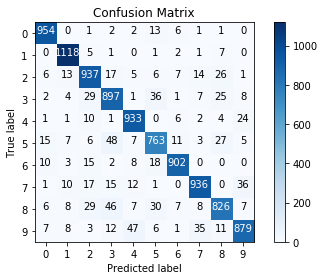

             precision    recall  f1-score   support

          0       0.98      0.99      0.99       980
          1       0.99      0.99      0.99      1135
          2       0.97      0.98      0.98      1032
          3       0.97      0.98      0.98      1010
          4       0.97      0.98      0.98       982
          5       0.98      0.96      0.97       892
          6       0.98      0.98      0.98       958
          7       0.98      0.97      0.98      1028
          8       0.98      0.97      0.97       974
          9       0.98      0.97      0.97      1009

avg / total       0.98      0.98      0.98     10000



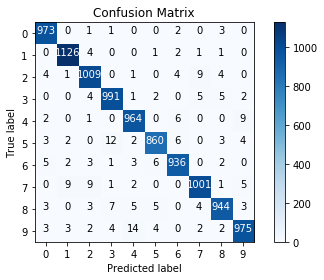

             precision    recall  f1-score   support

          0       0.96      0.99      0.98       980
          1       0.97      0.99      0.98      1135
          2       0.94      0.94      0.94      1032
          3       0.93      0.94      0.93      1010
          4       0.93      0.96      0.95       982
          5       0.93      0.91      0.92       892
          6       0.96      0.96      0.96       958
          7       0.95      0.94      0.95      1028
          8       0.94      0.91      0.93       974
          9       0.95      0.91      0.93      1009

avg / total       0.95      0.95      0.95     10000



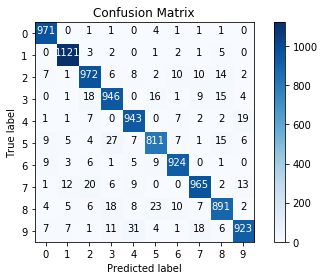

In [12]:
evaluation(all_clf, X_test, y_test)

## Conclusion
In summary, the linear kernel takes the longest training time, but performs poorest, with an average precision and recall of 91%, with largest confusions being between 3s and 5s and 3s and 8s. Close second is the rbf kernel, which performs at 95% average accuracy, with some issues at wrongly predicting 9s as 4s (and again confusing 3s and 5s). Only the polynomial kernel (degree 2) comes close to the ideal results reported on the MNIST website, with an error rate as low as 1-4% (2% average). Seeing as this classifier also has it's poorest performance with 3-5 and 4-9, an optimizing step could be to create an ensemble method that penalizes classifiers more heavily for mistakes on those classes (similar to boosting used in random forest ensembly methods).